In [1]:
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import seaborn as sns

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
else:
    device = torch.device
    print(f"Using {device}")



Using MPS (Apple Silicon GPU)


In [2]:
import torch

def check_cuda():
    if torch.cuda.is_available():
        print("✅ CUDA is available!")
        print(f"→ Device count: {torch.cuda.device_count()}")
        print(f"→ Current device: {torch.cuda.current_device()}")
        print(f"→ Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
        print(f"→ Device capability: {torch.cuda.get_device_capability(torch.cuda.current_device())}")
        device = torch.device("cuda")
    else:
        print("⚠️ CUDA not available. Falling back to CPU.")
        device = torch.device("cpu")
    return device

# 사용
device = check_cuda()


⚠️ CUDA not available. Falling back to CPU.


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Integer

columns = [
    'Stages', '_Lr1', '_Hr1',
    '_Lr2', '_Hr2', '_T_hex',
    '_Lr3', '_Hr3',
    'Shortcut_CAPEX', 'Shortcut_OPEX', 'Shortcut_AceticAcidWt', 'Shortcut_SplitRatio',
    'Shortcut_BoilupRatio_1', 'Shortcut_NumberStages_1', 'Shortcut_FeedStage_1', 
    'Shortcut_BoilupRatio_2','Shortcut_NumberStages_2', 'Shortcut_FeedStage_2',
    'Shortcut_BoilupRatio_3', 'Shortcut_NumberStages_3', 'Shortcut_FeedStage_3', 'Shortcut_Time',
    'Rigorous_CAPEX', 'Rigorous_OPEX', 'Rigorous_AceticAcidWt', 'Rigorous_Time'
]

# Create dataframe
results=pd.read_csv("/users/k23070952/MultiFidelity-ProcessOpt/3. Data/results_250327.csv")
results_df = pd.DataFrame(results.values, columns=columns)
results_df



,Stages,_Lr1,_Hr1,_Lr2,_Hr2,_T_hex,_Lr3,_Hr3,Shortcut_CAPEX,Shortcut_OPEX,...,Shortcut_NumberStages_2,Shortcut_FeedStage_2,Shortcut_BoilupRatio_3,Shortcut_NumberStages_3,Shortcut_FeedStage_3,Shortcut_Time,Rigorous_CAPEX,Rigorous_OPEX,Rigorous_AceticAcidWt,Rigorous_Time
0,22.496099,0.949791,0.213689,0.391686,0.394248,293.589294,0.609525,0.792393,1.2747,1.0233,...,1.0,1.0,0.280397,6.0,1.0,48.253299,1.2130,1.0411,0.659519,24.442365
1,2.792845,0.538156,0.920149,0.382160,0.561112,287.864881,0.754543,0.970123,1.2261,0.5682,...,4.0,4.0,0.046658,11.0,2.0,0.249246,1.1178,0.6431,0.082284,24.258789
2,26.862808,0.936113,0.751863,0.479950,0.328082,294.830085,0.526896,0.994976,1.3052,0.6685,...,2.0,2.0,0.050913,6.0,2.0,48.314961,1.1841,0.7099,0.363912,25.041893
3,22.026688,0.829354,0.775728,0.628023,0.404551,294.780062,0.498050,0.864402,1.4050,0.8206,...,5.0,4.0,0.169516,6.0,1.0,0.291054,1.3535,0.8955,0.276613,21.210174
4,42.015722,0.475290,0.463678,0.584915,0.488026,276.339784,0.815297,0.452160,1.5808,2.4733,...,6.0,6.0,1.263302,6.0,1.0,48.308530,1.6416,2.6437,0.176901,25.814667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29340,40.449502,0.434470,0.674743,0.388468,0.433860,311.408000,0.755874,0.626247,1.2487,1.2557,...,2.0,2.0,0.627277,6.0,1.0,0.508604,1.1689,1.3342,0.118157,4.088369
29341,47.066652,0.789421,0.155119,0.587968,0.453782,287.073269,0.003186,0.452736,1.1607,2.4542,...,6.0,6.0,1.160176,-2.0,0.0,0.432596,1.2989,2.5497,0.403593,8.048093
29342,23.429245,0.732517,0.534668,0.924039,0.592850,299.092087,0.715167,0.740391,1.5936,1.1319,...,16.0,12.0,0.374039,6.0,1.0,0.559330,1.4267,1.2250,0.858701,172.239917
29343,23.904669,0.955350,0.632037,0.728594,0.244677,287.486007,0.956225,0.925738,1.5772,0.8278,...,4.0,3.0,0.102955,12.0,1.0,0.313229,1.5514,0.8777,0.817903,6.919704


R² Score: 0.5193 (1.0이면 완전 선형, 0에 가까울수록 비선형)


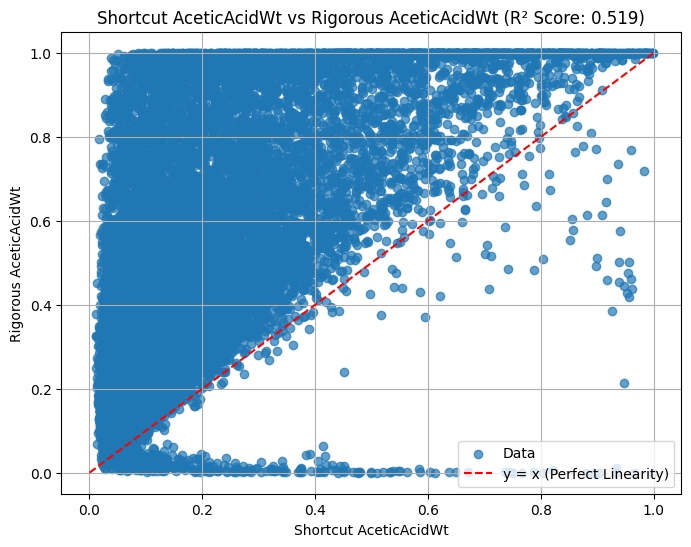

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Filter out invalid or NaN results for CAPEX
valid_results = results_df.dropna(subset=['Shortcut_AceticAcidWt', 'Rigorous_AceticAcidWt'])
valid_results['Rigorous_CAPEX'] = valid_results['Rigorous_CAPEX'].fillna(0)

valid_results = valid_results[(valid_results['Shortcut_AceticAcidWt'] > 0) & (valid_results['Rigorous_AceticAcidWt'] > 0) &
                                (valid_results['Shortcut_AceticAcidWt'] < 1) & (valid_results['Rigorous_AceticAcidWt'] < 1)]

# Scatter plot for CAPEX
plt.figure(figsize=(8, 6))
plt.scatter(valid_results['Shortcut_AceticAcidWt'], valid_results['Rigorous_AceticAcidWt'], alpha=0.7, label="Data")

# Add y = x reference line (Perfect linearity)
min_val = min(valid_results['Shortcut_AceticAcidWt'].min(), valid_results['Rigorous_AceticAcidWt'].min())
max_val = min(valid_results['Shortcut_AceticAcidWt'].max(), valid_results['Rigorous_AceticAcidWt'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x (Perfect Linearity)")



# Calculate R² score to check linearity
X = valid_results[['Shortcut_AceticAcidWt']].values
y = valid_results['Rigorous_AceticAcidWt'].values

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

print(f"R² Score: {r2:.4f} (1.0이면 완전 선형, 0에 가까울수록 비선형)")

plt.xlabel('Shortcut AceticAcidWt')
plt.ylabel('Rigorous AceticAcidWt')
plt.title(f'Shortcut AceticAcidWt vs Rigorous AceticAcidWt (R² Score: {r2:.3f})')
plt.legend()
plt.grid(True)
plt.show()


R² Score: 0.5723 (1.0이면 완전 선형, 0에 가까울수록 비선형)


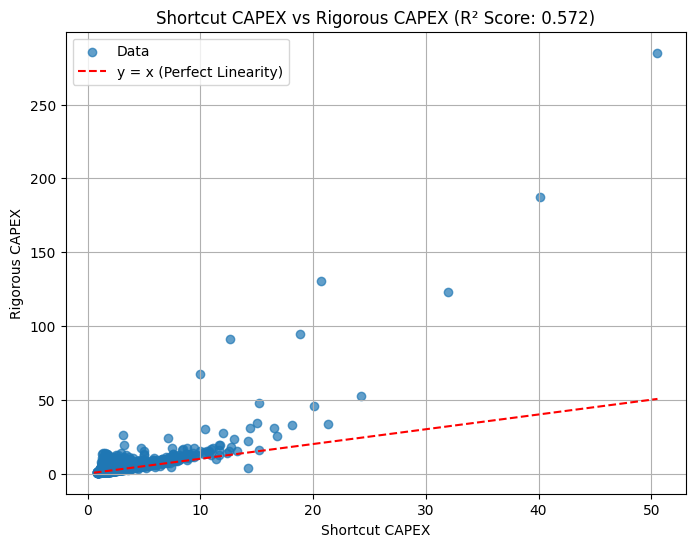

In [14]:
# Scatter plot for CAPEX
plt.figure(figsize=(8, 6))
plt.scatter(valid_results['Shortcut_CAPEX'], valid_results['Rigorous_CAPEX'], alpha=0.7, label="Data")

valid_results = valid_results[(valid_results['Rigorous_CAPEX'] > 0) & (valid_results['Rigorous_CAPEX'] <1000) &
                                (valid_results['Shortcut_CAPEX'] > 0)]
# Add y = x reference line (Perfect linearity)
min_val = min(valid_results['Shortcut_CAPEX'].min(), valid_results['Rigorous_CAPEX'].min())
max_val = min(valid_results['Shortcut_CAPEX'].max(), valid_results['Rigorous_CAPEX'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x (Perfect Linearity)")



# Calculate R² score to check linearity
X = valid_results[['Shortcut_CAPEX']].values
y = valid_results['Rigorous_CAPEX'].values

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

print(f"R² Score: {r2:.4f} (1.0이면 완전 선형, 0에 가까울수록 비선형)")

plt.xlabel('Shortcut CAPEX')
plt.ylabel('Rigorous CAPEX')
plt.title(f'Shortcut CAPEX vs Rigorous CAPEX (R² Score: {r2:.3f})')
plt.legend()
plt.grid(True)
plt.show()


R² Score: 0.9632 (1.0이면 완전 선형, 0에 가까울수록 비선형)


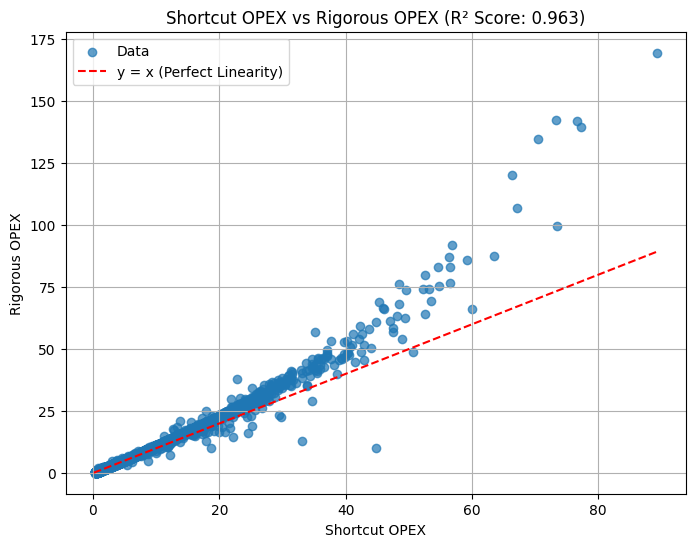

In [21]:
# Scatter plot for CAPEX
plt.figure(figsize=(8, 6))
plt.scatter(valid_results['Shortcut_OPEX'], valid_results['Rigorous_OPEX'], alpha=0.7, label="Data")

# Add y = x reference line (Perfect linearity)
min_val = min(valid_results['Shortcut_OPEX'].min(), valid_results['Rigorous_OPEX'].min())
max_val = min(valid_results['Shortcut_OPEX'].max(), valid_results['Rigorous_OPEX'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x (Perfect Linearity)")



# Calculate R² score to check linearity
X = valid_results[['Shortcut_OPEX']].values
y = valid_results['Rigorous_OPEX'].values

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

print(f"R² Score: {r2:.4f} (1.0이면 완전 선형, 0에 가까울수록 비선형)")

plt.xlabel('Shortcut OPEX')
plt.ylabel('Rigorous OPEX')
plt.title(f'Shortcut OPEX vs Rigorous OPEX (R² Score: {r2:.3f})')
plt.legend()
plt.grid(True)
plt.show()


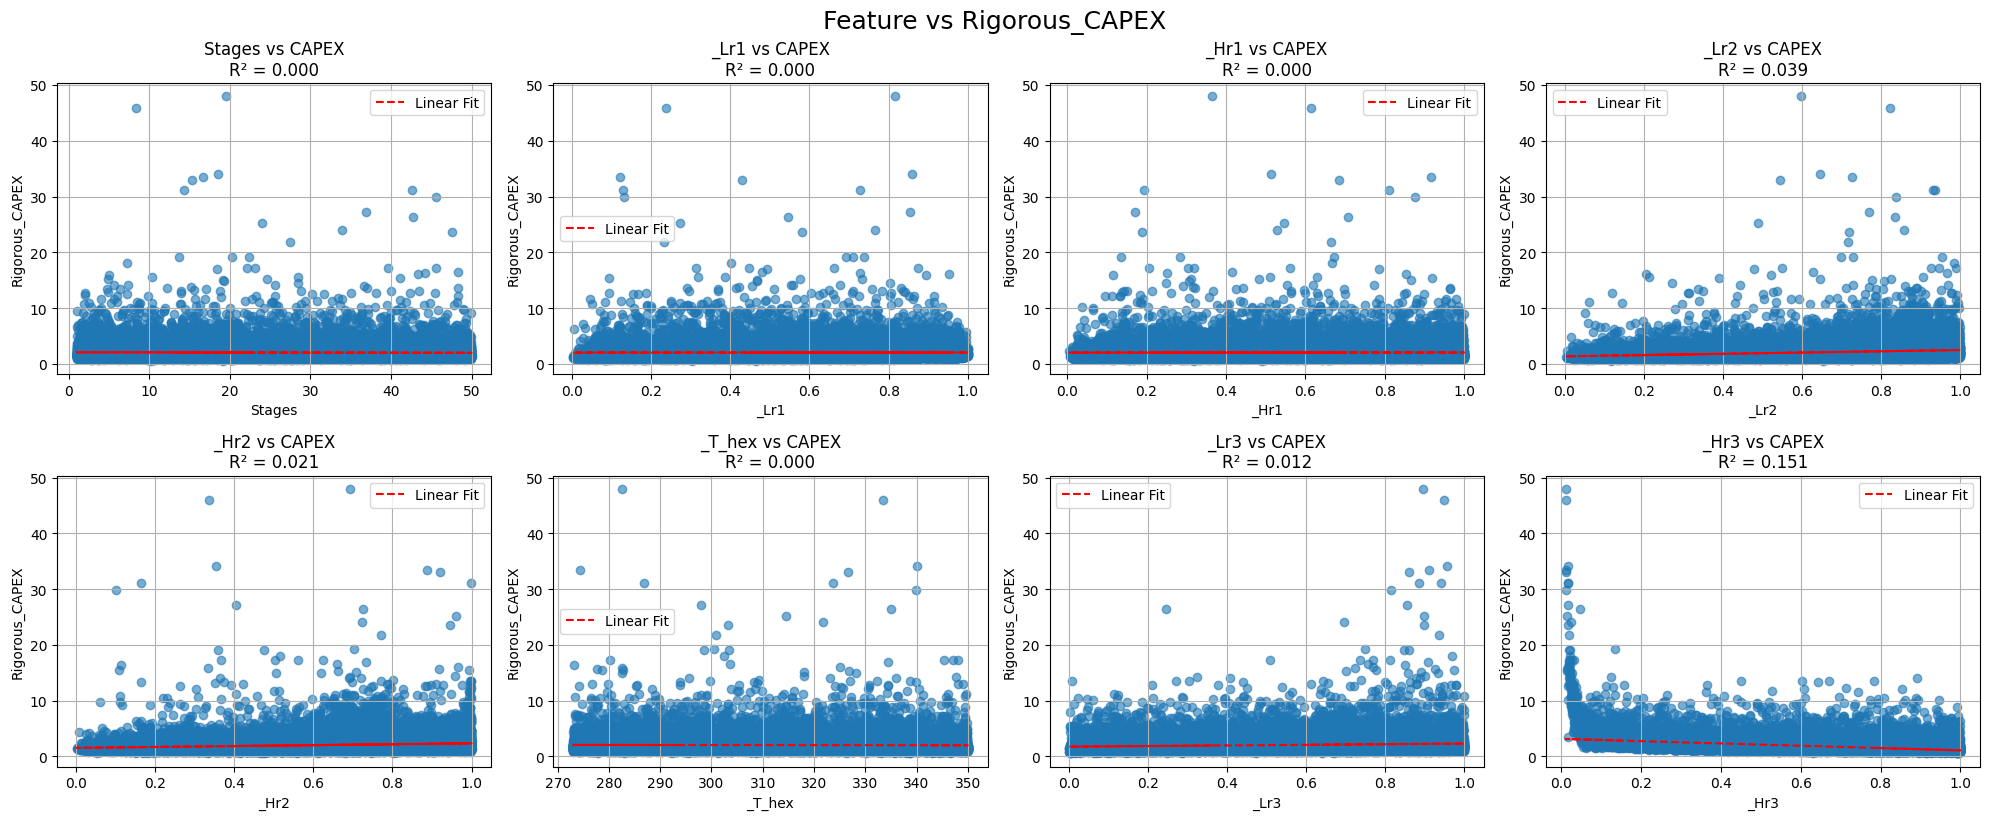

In [23]:
features = ['Stages', '_Lr1', '_Hr1', '_Lr2', '_Hr2', '_T_hex', '_Lr3', '_Hr3']
target = 'Rigorous_CAPEX'

filtered_df = valid_results[valid_results[target] < 50]


n_cols = 4  # 한 줄에 4개씩
n_rows = (len(features) + n_cols - 1) // n_cols

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for idx, feature in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, idx)
    
    X = filtered_df[[feature]].values
    y = filtered_df[target].values
    
    # NaN 처리 (선택적으로 적용)
    mask = ~np.isnan(X).flatten() & ~np.isnan(y)
    X = X[mask].reshape(-1, 1)
    y = y[mask]

    # 모델 적합 & 예측
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

    plt.scatter(X, y, alpha=0.6)
    plt.plot(X, y_pred, color='red', linestyle='--', label='Linear Fit')
    plt.title(f'{feature} vs CAPEX\nR² = {r2:.3f}')
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.suptitle("Feature vs Rigorous_CAPEX", fontsize=18, y=1.02)
plt.show()


In [17]:
valid_results.columns.to_list()

['Stages',
 '_Lr1',
 '_Hr1',
 '_Lr2',
 '_Hr2',
 '_T_hex',
 '_Lr3',
 '_Hr3',
 'Shortcut_CAPEX',
 'Shortcut_OPEX',
 'Shortcut_AceticAcidWt',
 'Shortcut_SplitRatio',
 'Shortcut_BoilupRatio_1',
 'Shortcut_NumberStages_1',
 'Shortcut_FeedStage_1',
 'Shortcut_BoilupRatio_2',
 'Shortcut_NumberStages_2',
 'Shortcut_FeedStage_2',
 'Shortcut_BoilupRatio_3',
 'Shortcut_NumberStages_3',
 'Shortcut_FeedStage_3',
 'Shortcut_Time',
 'Rigorous_CAPEX',
 'Rigorous_OPEX',
 'Rigorous_AceticAcidWt',
 'Rigorous_Time']

## 1. 리그레이션 모델링


In [62]:
def prepare_data(df):
    input_cols = ['Stages', '_Lr1', '_Hr1', '_Lr2', '_Hr2', '_T_hex', '_Lr3', '_Hr3']

    target_cols = [
        'Rigorous_CAPEX'
    ]

    X = df[input_cols].values
    y = df[target_cols].values
    return X, y, target_cols

def prepare_data_add_shortcut(df):
    input_cols = [ 'Stages', '_Lr1', '_Hr1',
                    '_Lr2', '_Hr2', '_T_hex',
                    '_Lr3', '_Hr3',
                    'Shortcut_CAPEX', 'Shortcut_OPEX', 'Shortcut_AceticAcidWt', 'Shortcut_SplitRatio',
                    'Shortcut_BoilupRatio_1', 'Shortcut_NumberStages_1', 'Shortcut_FeedStage_1', 
                    'Shortcut_BoilupRatio_2','Shortcut_NumberStages_2', 'Shortcut_FeedStage_2',
                    'Shortcut_BoilupRatio_3', 'Shortcut_NumberStages_3', 'Shortcut_FeedStage_3', ]
    
    target_cols = ['Rigorous_CAPEX']

    X = df[input_cols].values
    y = df[target_cols].values
    return X, y, target_cols


def run_linear_regression_with_validation(X, y, test_size=0.3, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    models, train_preds, test_preds = [], [], []
    train_mses, test_mses = [], []
    train_r2s, test_r2s = [], []

    for i in range(y.shape[1]):
        model = LinearRegression()
        model.fit(X_train, y_train[:, i])

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        train_mses.append(mean_squared_error(y_train[:, i], y_train_pred))
        test_mses.append(mean_squared_error(y_test[:, i], y_test_pred))
        train_r2s.append(r2_score(y_train[:, i], y_train_pred))
        test_r2s.append(r2_score(y_test[:, i], y_test_pred))

        models.append(model)
        train_preds.append(y_train_pred)
        test_preds.append(y_test_pred)

    return {
        'models': models,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_train_pred': np.array(train_preds).T,
        'y_test_pred': np.array(test_preds).T,
        'train_mse': train_mses,
        'test_mse': test_mses,
        'train_r2': train_r2s,
        'test_r2': test_r2s
    }


def run_random_forest_with_validation(X, y, num_int_data=None, n_iter = 10, test_size=0.4, random_state=1004):
    # 앞에서 num_int_data 만큼 학습, 나머지는 테스트
    X_train = X[:num_int_data]
    X_test = X[num_int_data:]
    y_train = y[:num_int_data]
    y_test = y[num_int_data:]

    models, train_preds, test_preds = [], [], []
    train_mses, test_mses = [], []
    train_r2s, test_r2s = [], []

    # 각 fold의 성능 저장용 리스트
    cv_mse_scores = []
    cv_r2_scores = []

    # Bayesian Optimization (1개 타깃 변수 기준)
    i = 0
    opt = BayesSearchCV(
        RandomForestRegressor(random_state=random_state),
        search_spaces={
            'n_estimators': Integer(50, 150),
            'max_depth': Integer(3, 10),
            'min_samples_leaf': Integer(1, 10),
        },
        n_iter=n_iter,
        scoring={
        'mse': 'neg_mean_squared_error',
        'r2': 'r2'
        },
        refit='mse',  # ✅ 이 줄이 핵심!
        return_train_score=True,
        random_state=random_state,
        n_jobs=-1,
        verbose=1
    )
    
    opt.fit(X_train, y_train[:, i])
    best_model = opt.best_estimator_

    # ✅ 각 fold별 CV 결과 저장
    results = opt.cv_results_
    print(results.keys())
    for k in range(n_iter): 
        mse_key = f'split{k}_test_mse'
        r2_key = f'split{k}_test_r2'

        for j in range(len(results['params'])):
            if mse_key in results:
                cv_mse_scores.append(-results[mse_key][j])  # 부호 바꾸기
            if r2_key in results:
                cv_r2_scores.append(results[r2_key][j])

    # 최적 모델 예측
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    train_mses.append(mean_squared_error(y_train[:, i], y_train_pred))
    test_mses.append(mean_squared_error(y_test[:, i], y_test_pred))
    train_r2s.append(r2_score(y_train[:, i], y_train_pred))
    test_r2s.append(r2_score(y_test[:, i], y_test_pred))

    models.append(best_model)
    train_preds.append(y_train_pred)
    test_preds.append(y_test_pred)

    return {
        'models': models,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_train_pred': np.array(train_preds).T,
        'y_test_pred': np.array(test_preds).T,
        'train_mse': train_mses,
        'test_mse': test_mses,
        'train_r2': train_r2s,
        'test_r2': test_r2s,
        'cv_mse_scores': cv_mse_scores,   # ✅ 추가
        'cv_r2_scores': cv_r2_scores      # ✅ 추가
    }



def run_xgboost_with_bayesian_optimization(X, y, test_size=0.2, random_state=1004, device='gpu', n_iter=100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    models, train_preds, test_preds = [], [], []
    train_mses, test_mses = [], []
    train_r2s, test_r2s = [], []

    for i in range(y.shape[1]):
        opt = BayesSearchCV(
                            XGBRegressor(
                                random_state=random_state,
                                tree_method="gpu_hist",  
                                predictor="gpu_predictor", 
                                device="cuda", 
                                verbosity=0
                            ),
                            search_spaces={
                                'n_estimators': Integer(50, 300),
                                'max_depth': Integer(3, 15),
                                'min_child_weight': Integer(1, 10),
                            },
                            n_iter=n_iter,
                            cv=5,
                            scoring='neg_mean_squared_error',
                            random_state=random_state,
                            n_jobs=-1,
                            verbose=1
                        )
        opt.fit(X_train, y_train[:, i])
        best_model = opt.best_estimator_

        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)

        train_mses.append(mean_squared_error(y_train[:, i], y_train_pred))
        test_mses.append(mean_squared_error(y_test[:, i], y_test_pred))
        train_r2s.append(r2_score(y_train[:, i], y_train_pred))
        test_r2s.append(r2_score(y_test[:, i], y_test_pred))

        models.append(best_model)
        train_preds.append(y_train_pred)
        test_preds.append(y_test_pred)

    return {
        'models': models,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_train_pred': np.array(train_preds).T,
        'y_test_pred': np.array(test_preds).T,
        'train_mse': train_mses,
        'test_mse': test_mses,
        'train_r2': train_r2s,
        'test_r2': test_r2s
    }


def plot_predictions_with_split(y_train_true, y_train_pred, y_test_true, y_test_pred,
                                 target_cols, train_mse, train_r2, test_mse, test_r2,
                                 title="Model Prediction Results"):
    n_targets = len(target_cols)
    ncols = 3
    nrows = int(np.ceil(n_targets / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4 * nrows))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()

    for i in range(n_targets):
        ax = axes[i]
        ax.scatter(y_train_true[:, i], y_train_pred[:, i], color='blue', alpha=0.6, label="Train")
        ax.scatter(y_test_true[:, i], y_test_pred[:, i], color='orange', alpha=0.6, label="Test")
        ax.plot([min(y_train_true[:, i].min(), y_test_true[:, i].min()),
                 max(y_train_true[:, i].max(), y_test_true[:, i].max())],
                [min(y_train_true[:, i].min(), y_test_true[:, i].min()),
                 max(y_train_true[:, i].max(), y_test_true[:, i].max())], 'r--')
        ax.set_title(f"{target_cols[i]}")
        ax.set_xlabel("Actual")
        ax.set_ylabel("Predicted")

        ax.text(0.05, 0.95,
                f"Train MSE: {train_mse[i]:.3f}\nTrain R²: {train_r2[i]:.3f}\n"
                f"Test MSE: {test_mse[i]:.3f}\nTest R²: {test_r2[i]:.3f}",
                transform=ax.transAxes,
                fontsize=9,
                verticalalignment='top',
                bbox=dict(boxstyle="round", fc="white", alpha=0.5))
        ax.legend()

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def plot_single_target_with_split(y_train_true, y_train_pred, y_test_true, y_test_pred,
                                   target_name, train_mse, train_r2, test_mse, test_r2,
                                   title="Model Prediction Results"):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_train_true, y_train_pred, color='blue', alpha=0.6, label="Train")
    plt.scatter(y_test_true, y_test_pred, color='orange', alpha=0.6, label="Test")

    y_min = min(y_train_true.min(), y_test_true.min())
    y_max = max(y_train_true.max(), y_test_true.max())
    plt.plot([y_min, y_max], [y_min, y_max], 'r--')

    plt.title(f"{title}\nTarget: {target_name}")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.legend()

    plt.text(0.05, 0.95,
             f"Train MSE: {train_mse:.3f}\nTrain R²: {train_r2:.3f}\n"
             f"Test MSE: {test_mse:.3f}\nTest R²: {test_r2:.3f}",
             transform=plt.gca().transAxes,
             fontsize=10,
             verticalalignment='top',
             bbox=dict(boxstyle="round", fc="white", alpha=0.5))

    plt.grid(True)
    plt.tight_layout()
    plt.show()

PCC 분석

In [56]:
def plot_correlation_matrix(df, title="Correlation Matrix"):
    corr = df.corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.8}, annot_kws={"size": 8},)
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return corr


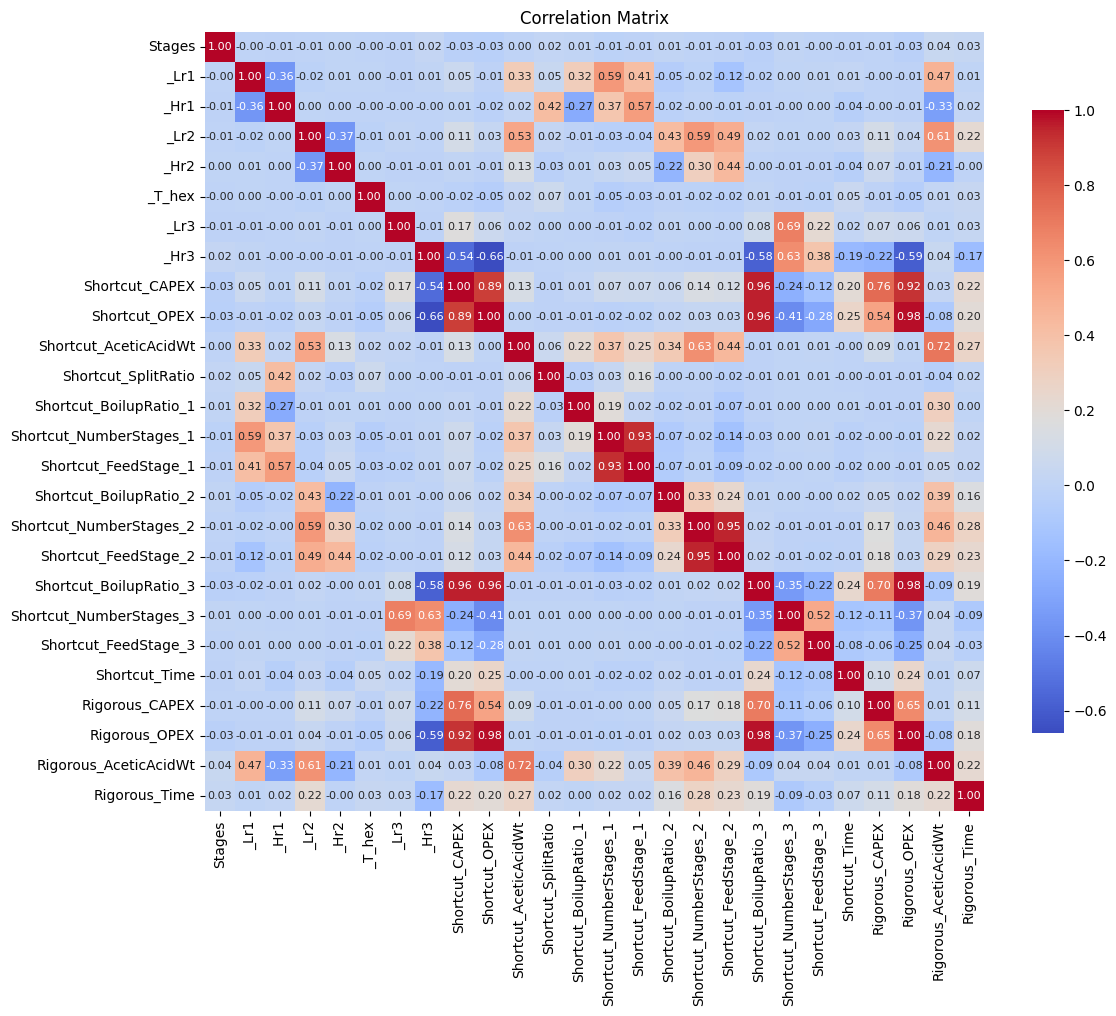

,Stages,_Lr1,_Hr1,_Lr2,_Hr2,_T_hex,_Lr3,_Hr3,Shortcut_CAPEX,Shortcut_OPEX,...,Shortcut_NumberStages_2,Shortcut_FeedStage_2,Shortcut_BoilupRatio_3,Shortcut_NumberStages_3,Shortcut_FeedStage_3,Shortcut_Time,Rigorous_CAPEX,Rigorous_OPEX,Rigorous_AceticAcidWt,Rigorous_Time
Stages,1.000000,-0.001529,-0.006735,-0.005302,0.003281,-0.004028,-0.009331,0.024651,-0.027617,-0.031601,...,-0.005354,-0.005744,-0.026793,0.009981,-0.000095,-0.008804,-0.005241,-0.026876,0.042267,0.031981
_Lr1,-0.001529,1.000000,-0.363236,-0.015292,0.006321,0.004503,-0.006456,0.008480,0.053468,-0.008123,...,-0.016818,-0.122930,-0.021953,0.002735,0.009925,0.014798,-0.004074,-0.009067,0.469938,0.007096
_Hr1,-0.006735,-0.363236,1.000000,0.003145,0.001012,-0.000669,-0.002114,-0.003579,0.007046,-0.019964,...,-0.004983,-0.013123,-0.011711,-0.001986,0.001864,-0.038841,-0.001692,-0.010410,-0.326797,0.016448
_Lr2,-0.005302,-0.015292,0.003145,1.000000,-0.368233,-0.013247,0.012620,-0.002438,0.110030,0.033095,...,0.587158,0.494300,0.015554,0.005038,0.003992,0.025893,0.109995,0.036383,0.612161,0.215204
_Hr2,0.003281,0.006321,0.001012,-0.368233,1.000000,0.002975,-0.007466,-0.007576,0.010165,-0.006555,...,0.299739,0.437926,-0.000579,-0.007986,-0.011426,-0.039621,0.065100,-0.009490,-0.212064,-0.003336
_T_hex,-0.004028,0.004503,-0.000669,-0.013247,0.002975,1.000000,0.004025,-0.004070,-0.023004,-0.046815,...,-0.015127,-0.024091,0.013650,-0.007956,-0.014019,0.049267,-0.005927,-0.047345,0.014505,0.033857
_Lr3,-0.009331,-0.006456,-0.002114,0.012620,-0.007466,0.004025,1.000000,-0.010188,0.173524,0.061368,...,0.001801,-0.004507,0.081866,0.687000,0.218002,0.017798,0.074902,0.063874,0.006958,0.033460
_Hr3,0.024651,0.008480,-0.003579,-0.002438,-0.007576,-0.004070,-0.010188,1.000000,-0.539275,-0.660565,...,-0.007383,-0.008705,-0.581752,0.633523,0.376629,-0.188681,-0.223184,-0.592729,0.041319,-0.172827
Shortcut_CAPEX,-0.027617,0.053468,0.007046,0.110030,0.010165,-0.023004,0.173524,-0.539275,1.000000,0.889842,...,0.142168,0.119111,0.957161,-0.240040,-0.123363,0.204843,0.756526,0.917341,0.025079,0.223868
Shortcut_OPEX,-0.031601,-0.008123,-0.019964,0.033095,-0.006555,-0.046815,0.061368,-0.660565,0.889842,1.000000,...,0.029353,0.033356,0.960959,-0.413932,-0.280374,0.254526,0.542381,0.981416,-0.080971,0.200913


In [57]:
plot_correlation_matrix(valid_results)

## Modelling-RF

In [58]:
valid_results

,Stages,_Lr1,_Hr1,_Lr2,_Hr2,_T_hex,_Lr3,_Hr3,Shortcut_CAPEX,Shortcut_OPEX,...,Shortcut_NumberStages_2,Shortcut_FeedStage_2,Shortcut_BoilupRatio_3,Shortcut_NumberStages_3,Shortcut_FeedStage_3,Shortcut_Time,Rigorous_CAPEX,Rigorous_OPEX,Rigorous_AceticAcidWt,Rigorous_Time
0,22.496099,0.949791,0.213689,0.391686,0.394248,293.589294,0.609525,0.792393,1.2747,1.0233,...,1.0,1.0,0.280397,6.0,1.0,48.253299,1.2130,1.0411,0.659519,24.442365
1,2.792845,0.538156,0.920149,0.382160,0.561112,287.864881,0.754543,0.970123,1.2261,0.5682,...,4.0,4.0,0.046658,11.0,2.0,0.249246,1.1178,0.6431,0.082284,24.258789
2,26.862808,0.936113,0.751863,0.479950,0.328082,294.830085,0.526896,0.994976,1.3052,0.6685,...,2.0,2.0,0.050913,6.0,2.0,48.314961,1.1841,0.7099,0.363912,25.041893
3,22.026688,0.829354,0.775728,0.628023,0.404551,294.780062,0.498050,0.864402,1.4050,0.8206,...,5.0,4.0,0.169516,6.0,1.0,0.291054,1.3535,0.8955,0.276613,21.210174
4,42.015722,0.475290,0.463678,0.584915,0.488026,276.339784,0.815297,0.452160,1.5808,2.4733,...,6.0,6.0,1.263302,6.0,1.0,48.308530,1.6416,2.6437,0.176901,25.814667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29340,40.449502,0.434470,0.674743,0.388468,0.433860,311.408000,0.755874,0.626247,1.2487,1.2557,...,2.0,2.0,0.627277,6.0,1.0,0.508604,1.1689,1.3342,0.118157,4.088369
29341,47.066652,0.789421,0.155119,0.587968,0.453782,287.073269,0.003186,0.452736,1.1607,2.4542,...,6.0,6.0,1.160176,-2.0,0.0,0.432596,1.2989,2.5497,0.403593,8.048093
29342,23.429245,0.732517,0.534668,0.924039,0.592850,299.092087,0.715167,0.740391,1.5936,1.1319,...,16.0,12.0,0.374039,6.0,1.0,0.559330,1.4267,1.2250,0.858701,172.239917
29343,23.904669,0.955350,0.632037,0.728594,0.244677,287.486007,0.956225,0.925738,1.5772,0.8278,...,4.0,3.0,0.102955,12.0,1.0,0.313229,1.5514,0.8777,0.817903,6.919704


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_min_samples_leaf', 'param_n_estimators', 'params', 'split0_test_mse', 'split1_test_mse', 'split2_test_mse', 'split3_test_mse', 'split4_test_mse', 'mean_test_mse', 'std_test_mse', 'rank_test_mse', 'split0_train_mse', 'split1_train_mse', 'split2_train_mse', 'split3_train_mse', 'split4_train_mse', 'mean_t

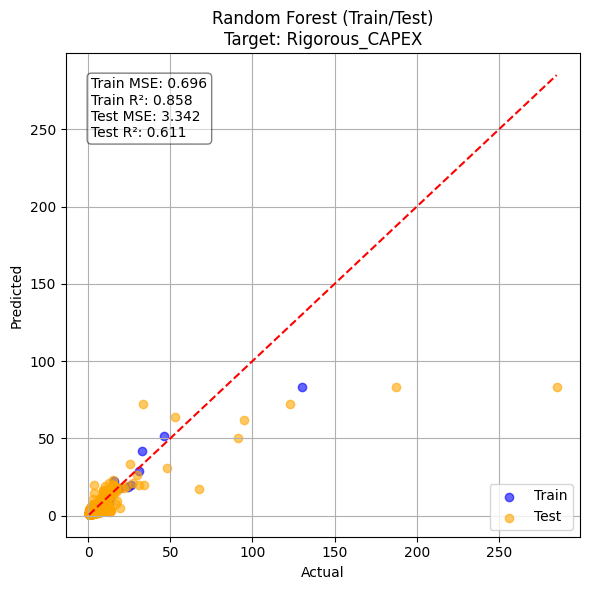

In [91]:

# 데이터프레임 불러오기 (예시)
data = valid_results  # 또는 위에서 제공한 dict 기반으로 DataFrame 직접 생성
X, y, target_cols = prepare_data_add_shortcut(data)

# Linear Regression 실행
result = run_random_forest_with_validation(X, y, num_int_data = 6400)  # y.shape = (n_samples, 1)

plot_single_target_with_split(
    y_train_true=result['y_train'].flatten(),
    y_train_pred=result['y_train_pred'].flatten(),
    y_test_true=result['y_test'].flatten(),
    y_test_pred=result['y_test_pred'].flatten(),
    target_name='Rigorous_CAPEX',
    train_mse=result['train_mse'][0],
    train_r2=result['train_r2'][0],
    test_mse=result['test_mse'][0],
    test_r2=result['test_r2'][0],
    title="Random Forest (Train/Test)"
)



In [92]:
result['cv_mse_scores']

[0.8331802106459352,
 0.900317348271153,
 0.9134337415824177,
 0.9111498823251578,
 0.8378410135474749,
 0.9131564355411778,
 0.8756787323117908,
 0.8787314137265622,
 0.8564637664082015,
 0.8285128734125415,
 0.947840802798704,
 0.9035937096963866,
 0.9081933381356488,
 0.7395315405511035,
 1.2209268479828617,
 0.7785422495869684,
 0.7519180026849682,
 0.870377874192496,
 0.8577720073754224,
 1.28893611377003,
 2.020466934718418,
 1.0254919465836254,
 1.0367339428406226,
 1.3968069438747408,
 1.023266789741569,
 1.7174533961946021,
 1.7147726329251078,
 1.0179308691473419,
 1.0415719237058498,
 1.3115732181685638,
 9.018679099978021,
 10.619482155833932,
 10.459967652425672,
 9.622487436179162,
 8.100629927268205,
 9.471802804824886,
 9.47489210073333,
 10.617589115586336,
 10.452058480627455,
 8.507480444983704,
 1.0243081813785513,
 1.4419223855189396,
 1.4072100392198057,
 1.4172085779131005,
 0.7780311978260828,
 1.399476643372442,
 1.372051313621542,
 1.4293376917729497,
 1.37478

In [94]:
result['cv_r2_scores']

[0.5055712817389684,
 0.46573052642624146,
 0.4579469503760272,
 0.45930224613416837,
 0.5028054517597744,
 0.4581115102980998,
 0.4803516601892108,
 0.478540127294071,
 0.4917542725433566,
 0.5083409893442531,
 0.5568738493173195,
 0.5775598590221498,
 0.5754094814072143,
 0.6542607535936191,
 0.4292030762821226,
 0.6360228118639295,
 0.64846994434617,
 0.5930886327203149,
 0.5989820161051349,
 0.3974079857246807,
 0.31101428916063445,
 0.6503039541820406,
 0.6464703973693625,
 0.523684348110838,
 0.6510627398083775,
 0.41434287853093177,
 0.4152570274116122,
 0.6528823058603744,
 0.64482063036344,
 0.5527493221938423,
 0.3700822132928441,
 0.25827267813583143,
 0.2694141126874686,
 0.3279086747381704,
 0.43420418687133777,
 0.33843337890174363,
 0.3382176042390067,
 0.2584048992415715,
 0.2699665359346636,
 0.4057873450257693,
 0.7075419567574588,
 0.5883057393830979,
 0.5982167261930825,
 0.5953619671325912,
 0.7778583771618097,
 0.600424747039012,
 0.6082551621621588,
 0.5918988913

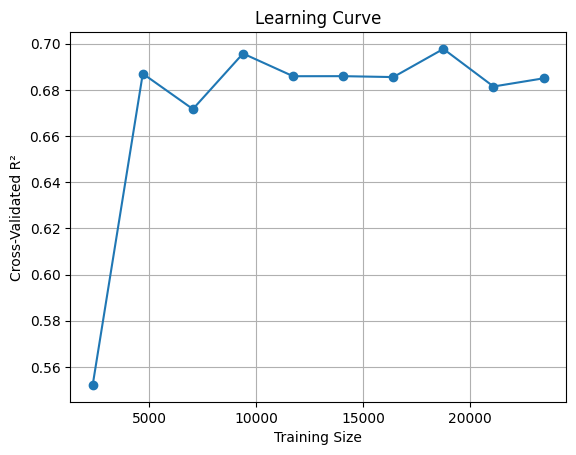

In [45]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator=LinearRegression(), X=X, y=y,
    train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='r2'
)

mean_test_scores = test_scores.mean(axis=1)

plt.plot(train_sizes, mean_test_scores, marker='o')
plt.xlabel("Training Size")
plt.ylabel("Cross-Validated R²")
plt.title("Learning Curve")
plt.grid(True)
plt.show()


## Modelling-XGB

Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: 

/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [7, 3, 190]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [5, 6, 129]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [13, 6, 102]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [6, 8, 218]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [14, 5, 236]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [11, 10, 292]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [6, 3, 231]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [11, 8, 192]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [12, 5, 259]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [9, 5, 131]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [8, 8, 178]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [5, 2, 156]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [12, 7, 257]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [14, 6, 241]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [14, 7, 227]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [15, 7, 128]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [8, 4, 224]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [8, 6, 216]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [3, 2, 86]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [3, 2, 172]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [15, 9, 238]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [5, 3, 248]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [5, 8, 224]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [12, 8, 242]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [14, 4, 205]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [5, 10, 166]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [10, 5, 190]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [10, 9, 271]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [13, 3, 157]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [14, 3, 104]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [12, 1, 115]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [4, 5, 100]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [14, 3, 167]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [6, 8, 147]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [12, 2, 135]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [7, 7, 243]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [14, 3, 177]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [10, 9, 133]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [7, 1, 297]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [10, 6, 223]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [9, 3, 197]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [6, 3, 109]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [9, 7, 56]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [5, 7, 170]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [14, 3, 128]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [4, 5, 207]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [9, 9, 201]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [7, 5, 221]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [3, 2, 182]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 10, 50] before, using random point [4, 7, 216]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [9, 3, 276]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [5, 4, 68]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [9, 7, 96]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [11, 7, 135]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [5, 3, 185]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [13, 3, 99]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [3, 9, 66]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [11, 6, 255]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [5, 9, 180]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [10, 9, 92]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [6, 6, 235]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [9, 8, 88]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [11, 4, 173]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [14, 4, 296]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [10, 7, 161]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [13, 3, 161]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/users/k23070952/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 9, 50] before, using random point [14, 10, 232]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


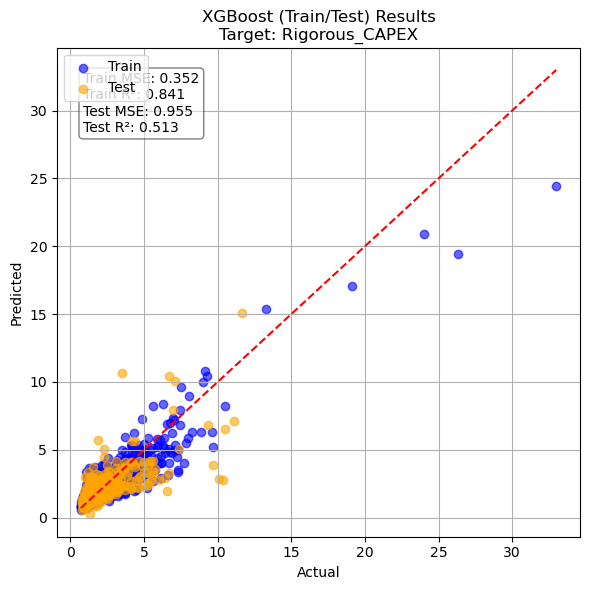

In [54]:
# XGBoost 실행
data = valid_results  # 또는 위에서 제공한 dict 기반으로 DataFrame 직접 생성
X, y, target_cols = prepare_data_add_shortcut(data)
xgb_result = run_xgboost_with_bayesian_optimization(X, y)  # 또는 'auto'

# 같은 시각화 함수 사용
plot_single_target_with_split(
    y_train_true=xgb_result['y_train'].flatten(),
    y_train_pred=xgb_result['y_train_pred'].flatten(),
    y_test_true=xgb_result['y_test'].flatten(),
    y_test_pred=xgb_result['y_test_pred'].flatten(),
    target_name=target_cols[0],  # 리스트 → 문자열
    train_mse=xgb_result['train_mse'][0],
    train_r2=xgb_result['train_r2'][0],
    test_mse=xgb_result['test_mse'][0],
    test_r2=xgb_result['test_r2'][0],
    title="XGBoost (Train/Test) Results"
)


In [36]:
y

array([ 1.0411,  2.1216,  3.3564,  1.6083,  4.9985,  0.7796,  1.6426,
        2.0584,  3.5415,  1.9983,  0.9419,  3.7745,  2.4439,  1.7506,
        2.5979,  0.8413,  0.9266,  0.8305,  0.9581,  1.3969,  0.5023,
        2.5345,  8.0784,  1.2348,  1.0617, 12.9642,  1.4446,  1.3113,
        1.3189,  3.7475,  1.6455,  2.5483,  3.3498,  2.1755,  4.3133,
        4.9209,  5.8431,  1.5813,  5.4984,  0.3166,  1.908 ,  1.3161,
        1.0752,  1.3341,  0.8173,  3.1432,  1.1257,  0.7724,  2.1078,
        0.8132,  5.4971,  2.2409,  1.1548,  0.7371,  1.3485,  7.8766,
        7.3   ,  1.8244,  1.8782,  1.3883, 10.3517,  1.0948,  0.3864,
        4.7105,  0.6877, 15.8619,  0.8758,  1.2879,  4.1769,  1.767 ,
        3.9532,  1.0477,  1.2014,  0.7387,  1.3556,  1.6391,  2.2057,
        2.1639,  1.0973,  0.9449,  1.6574,  0.9944,  4.9777,  1.3057,
        0.9477,  0.8362,  1.2852,  3.3595,  2.9547,  0.9453,  1.3121,
        0.5499, 11.5979,  5.6167,  3.5765,  3.0731,  1.8523,  1.4297,
        1.6082,  8.0

## Modelling-add Shortcut_OPEX

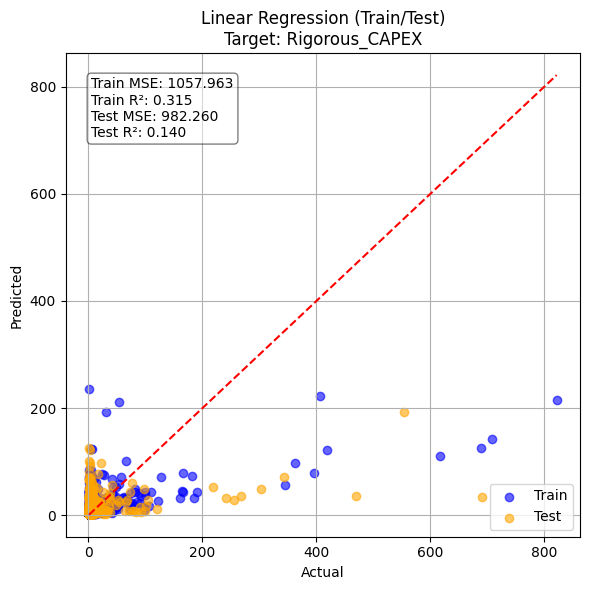

In [28]:

# 데이터프레임 불러오기 (예시)
data = valid_results  # 또는 위에서 제공한 dict 기반으로 DataFrame 직접 생성
X, y, target_cols = prepare_data_add_shortcut(data)

    # Linear Regression 실행
result = run_random_forest_with_validation(X, y)  # y.shape = (n_samples, 1)

plot_single_target_with_split(
    y_train_true=result['y_train'].flatten(),
    y_train_pred=result['y_train_pred'].flatten(),
    y_test_true=result['y_test'].flatten(),
    y_test_pred=result['y_test_pred'].flatten(),
    target_name='Rigorous_CAPEX',
    train_mse=result['train_mse'][0],
    train_r2=result['train_r2'][0],
    test_mse=result['test_mse'][0],
    test_r2=result['test_r2'][0],
    title="Linear Regression (Train/Test)"
)


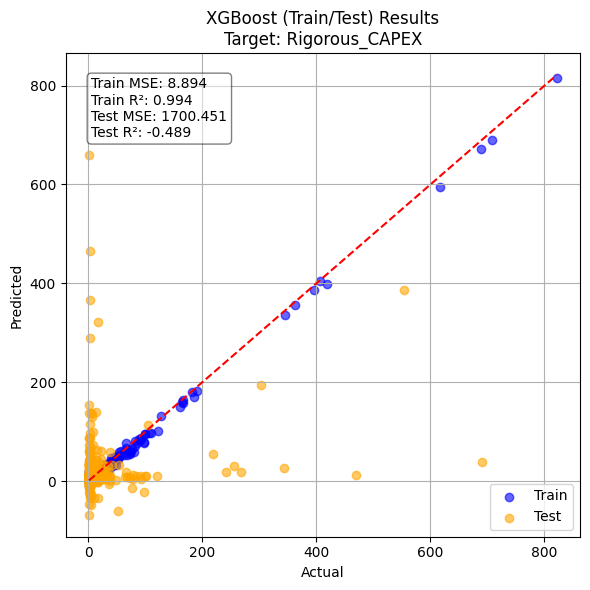

In [29]:
# XGBoost 실행
xgb_result = run_xgboost_with_validation(X, y, device='cpu')  # 또는 'auto'

# 같은 시각화 함수 사용
plot_single_target_with_split(
    y_train_true=xgb_result['y_train'].flatten(),
    y_train_pred=xgb_result['y_train_pred'].flatten(),
    y_test_true=xgb_result['y_test'].flatten(),
    y_test_pred=xgb_result['y_test_pred'].flatten(),
    target_name=target_cols[0],  # 리스트 → 문자열
    train_mse=xgb_result['train_mse'][0],
    train_r2=xgb_result['train_r2'][0],
    test_mse=xgb_result['test_mse'][0],
    test_r2=xgb_result['test_r2'][0],
    title="XGBoost (Train/Test) Results"
)